In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# enable interactive plots
%matplotlib widget

# formatting
import fig_specs as fsp
plt.rcParams['figure.figsize'] = (10, 10)  # set default figure size
plt.rcParams['font.family'] = 'sans-serif'          # set default font size
plt.rcParams['font.sans-serif'] = 'Helvetica'          # set default font size
plt.rcParams['font.size'] = 9          # set default font size
plt.rcParams['savefig.bbox'] = 'tight'

# Import and concatenate all 4D results data into suitable dataframes

In [2]:
import os
import pickle

# Set the directory containing the CSV files
csv_dir = './results/4d/results'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Concatenate all CSV files into a single dataframe
df_sim = pd.concat([pd.read_csv(os.path.join(csv_dir, f)) for f in csv_files])

# Load pickled train time dataframe
with open('./benchmark-policies/4d/wind_0,9_train_time.pkl', 'rb') as f:
    df_train = pickle.load(f)





# Modify df_train
# Create new columns
df_train['grid_size'] = df_train.index.str.extract(r'^(\d{1,2})\d{1}', expand=False).astype(int)
df_train['obstacle_density'] = df_train.index.str.extract(r'^\d{1,2}(\d{1})', expand=False).astype(int)

# define a dictionary to map the old "density" values to new percentage values
mapping = {1: 0, 2: 0.05, 3: 0.10, 4: 0.15}

# replace the old values with the new values
df_train['obstacle_density'] = df_train['obstacle_density'].replace(mapping)



# Modify df_sim
# Create new columns
df_sim['grid_size'] = df_sim['MDP_ID'].astype(str).str.extract(r'^(\d{1,2})\d{1}', expand=False).astype(int)
df_sim['obstacle_density'] = df_sim['MDP_ID'].astype(str).str.extract(r'^\d{1,2}(\d{1})', expand=False).astype(int)

# define a dictionary to map the old "density" values to new percentage values
mapping = {1: 0, 2: 0.05, 3: 0.10, 4: 0.15}

# replace the old values with the new values
df_sim['obstacle_density'] = df_sim['obstacle_density'].replace(mapping)

In [3]:
df_sim.head()

,dimension,MDP_ID,wind_param,sol_method,l1_norm,no_solutions,solver_time,grid_size,obstacle_density
0,4,131,0.8,IP,0.0,5.0,0.610973,13,0.0
1,4,131,0.8,IP,10.0,13.0,1.634126,13,0.0
2,4,131,0.8,IP,4.0,7.0,0.911011,13,0.0
3,4,131,0.8,IP,2.0,7.0,0.919262,13,0.0
4,4,131,0.8,IP,2.0,7.0,0.931227,13,0.0


In [4]:
df_train.head()

,DP4,MC4,grid_size,obstacle_density
"41_wind_0,9",1.767049,0.336776,4,0.00
"42_wind_0,9",1.755515,0.339481,4,0.05
"43_wind_0,9",1.678167,0.310009,4,0.10
"44_wind_0,9",1.589444,0.298224,4,0.15
"51_wind_0,9",4.588190,0.717241,5,0.00


# Plot stuff

## RL

### Training time trends

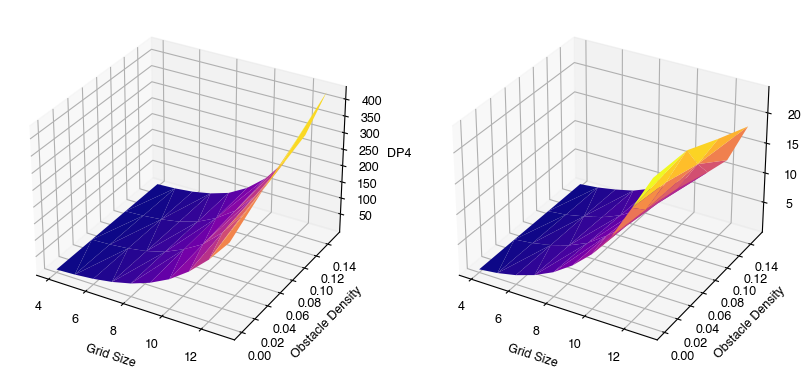

In [5]:
fig = plt.figure()

# First subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(df_train['grid_size'], df_train['obstacle_density'], df_train['DP4'], cmap='plasma')
ax1.set_xlabel('Grid Size')
ax1.set_ylabel('Obstacle Density')
ax1.set_zlabel('DP4')


# Second subplot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(df_train['grid_size'], df_train['obstacle_density'], df_train['MC4'], cmap='plasma')
ax2.set_xlabel('Grid Size')
ax2.set_ylabel('Obstacle Density')
ax2.set_zlabel('MC4 Train Time (seconds)')


plt.show()

Now plot training times but in contour plots instead!

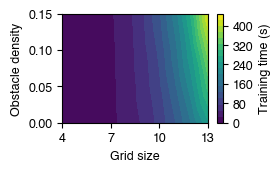

In [6]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

method = 'dp'

ax = fig.add_subplot()
# Get the x, y, z values
x, y, z_train_mc = df_train['grid_size'], df_train['obstacle_density'], df_train['MC4']
z_train_dp = df_train['DP4']

# Create a triangulation of the irregular grid
triang = tri.Triangulation(x, y)

# Plot the contour
if method == 'mc':
    #levels = np.linspace(0, 1, 17)
    cs = ax.tricontourf(triang, z_train_mc, levels = 18, cmap='plasma')
    cbar = plt.colorbar(cs, ax=ax)
    cbar.locator = MaxNLocator(7) # this number sets maximum number of colour bar ticks
elif method == 'dp':
    #levels = np.linspace(0, 0.5, 11)
    cs = ax.tricontourf(triang, z_train_dp, levels = 18, cmap='viridis')
    cbar = plt.colorbar(cs, ax=ax)
    cbar.locator = MaxNLocator(6) # this number sets maximum number of colour bar ticks

# Set labels for the axes
ax.set_xlabel('Grid size')
ax.set_ylabel('Obstacle density')
cbar.ax.set_ylabel('Training time (s)')
ax.set_yticks(np.arange(0, 0.16, 0.05))
ax.set_xticks(np.arange(4,14,3))
plt.grid(False)

save = False
plt.tight_layout()
if save:
    plt.savefig(f'{fsp.fig_path}/4d-{method}-train-times-wind-0.9.pdf')
plt.show()

It's clear that, although the training time trend with respect to grid size is similar, that with respect to obstacle density is not.
Although more obstacles implies more time in computing stuff (whether that's state space backups in DP or experienced simulations in MC), another factor affects the time in MC — the length of simulations. More obstacles --> more crashes --> shorter simulations --> less time to simulate.

### RL Performance trends

In [7]:
df_sim[df_sim['sol_method'].isin(['DP', 'MC'])].head()

,dimension,MDP_ID,wind_param,sol_method,l1_norm,no_solutions,solver_time,grid_size,obstacle_density
300,4,131,0.8,MC,3.0,NaN,NaN,13,0.0
301,4,131,0.8,MC,0.0,NaN,NaN,13,0.0
302,4,131,0.8,MC,3.0,NaN,NaN,13,0.0
303,4,131,0.8,MC,2.0,NaN,NaN,13,0.0
304,4,131,0.8,MC,3.0,NaN,NaN,13,0.0


/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/2328342393.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/2328342393.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/2328342393.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean 

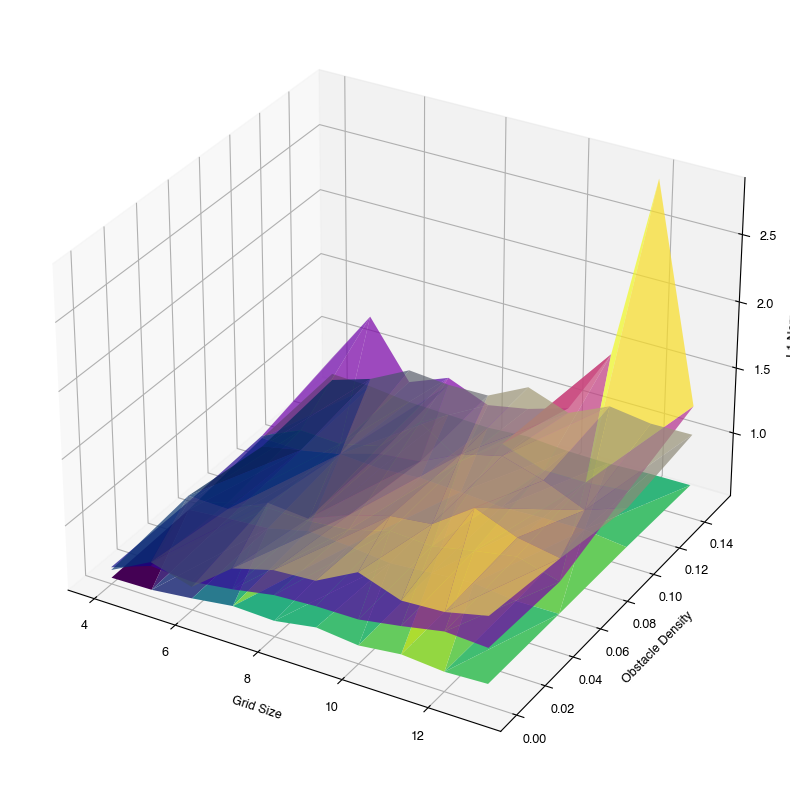

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

df_sim_mc = df_sim[df_sim['sol_method'] == 'MC']
data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
df_sim_dp = df_sim[df_sim['sol_method'] == 'DP']
data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
df_sim_ip = df_sim[df_sim['sol_method'] == 'IP']
data_ip = df_sim_ip.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()

wind_param_vals = [0.95]

for wp in wind_param_vals:
    norm_data_mc = data_mc.loc[:, :, wp]['l1_norm']
    norm_data_dp = data_dp.loc[:, :, wp]['l1_norm']
    norm_data_ip = data_ip.loc[:, :, wp]['l1_norm']

    # Get the x, y, z values
    x = norm_data_mc.index.get_level_values('grid_size')
    y = norm_data_mc.index.get_level_values('obstacle_density')
    z_mc = norm_data_mc.values
    z_dp = norm_data_dp.values
    z_ip = norm_data_ip.values

    # Plot the 3D surfaces
    ax.plot_trisurf(x, y, z_mc, cmap='plasma', alpha = 0.7)
    ax.plot_trisurf(x, y, z_dp, cmap='viridis', alpha = 1)
    ax.plot_trisurf(x, y, z_ip, cmap='cividis', alpha = 0.7)


# Set labels for the axes
ax.set_xlabel('Grid Size')
ax.set_ylabel('Obstacle Density')
ax.set_zlabel('L1 Norm')

plt.show()


In [9]:
crash_rates_ip = df_sim_ip.groupby(['grid_size', 'obstacle_density', 'wind_param'])['l1_norm'].apply(lambda x: x.isna().sum() / len(x))
crash_rates_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param'])['l1_norm'].apply(lambda x: x.isna().sum() / len(x))
crash_rates_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param'])['l1_norm'].apply(lambda x: x.isna().sum() / len(x))

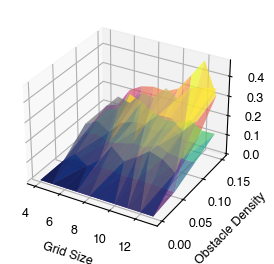

In [10]:
fig = plt.figure(figsize=(fsp.text_width, 3))
ax = fig.add_subplot(111, projection='3d')

wind_param_vals = [0.95]

for wp in wind_param_vals:

    # Get the x, y, z values
    z_mc = crash_rates_mc.loc[:, :, wp]
    z_dp = crash_rates_dp.loc[:, :, wp]
    z_ip = crash_rates_ip.loc[:, :, wp]
    
    x = z_mc.index.get_level_values('grid_size')
    y = z_mc.index.get_level_values('obstacle_density')

    # Plot the 3D surfaces
    ax.plot_trisurf(x, y, z_mc, cmap='plasma', alpha = 0.7)
    ax.plot_trisurf(x, y, z_dp, cmap='viridis', alpha = 0.7)
    ax.plot_trisurf(x, y, z_ip, cmap='cividis', alpha = 0.7)


# Set labels for the axes
ax.set_xlabel('Grid Size')
ax.set_ylabel('Obstacle Density')
ax.set_zlabel('Crash rate')
ax.set_yticks(np.arange(0, 0.16, 0.05))

plt.show()

### Plot crash rates as contours, ready for report

First we fix wind values!

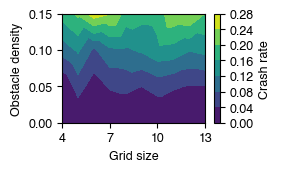

In [87]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

fig = plt.figure(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

wind_param_vals = [0.9]
method = 'dp'

for i, wp in enumerate(wind_param_vals):
    ax = fig.add_subplot(len(wind_param_vals), 1, i+1)
    
    # Get the x, y, z values
    z_mc = crash_rates_mc.loc[:, :, wp]
    z_dp = crash_rates_dp.loc[:, :, wp]
    z_ip = crash_rates_ip.loc[:, :, wp]
    
    x = z_mc.index.get_level_values('grid_size')
    y = z_mc.index.get_level_values('obstacle_density')

    # Create a triangulation of the irregular grid
    triang = tri.Triangulation(x, y)

    # Plot the contour
    if method == 'mc':
        cs = ax.tricontourf(triang, z_mc, cmap='plasma')
    elif method == 'ip':
        cs = ax.tricontourf(triang, z_ip, cmap='cividis')
    elif method == 'dp':
        cs = ax.tricontourf(triang, z_dp, cmap='viridis')

    # Add a colorbar to show the scale of the values in the contours
    cbar = plt.colorbar(cs, ax=ax)

    # Set labels for the axes
    ax.set_xlabel('Grid size')
    ax.set_ylabel('Obstacle density')
    cbar.ax.set_ylabel('Crash rate')
    ax.set_yticks(np.arange(0, 0.16, 0.05))
    ax.set_xticks(np.arange(4, 14, 3))
    #ax.set_title(f'Wind Parameter = {wp}')
    plt.grid(False)


save = False
plt.tight_layout()
if save:
    plt.savefig(f'{fsp.fig_path}/4d-{method}-crash-rates-wind-{wind_param_vals[0]}.pdf')
plt.show()

Now we fix grid size!

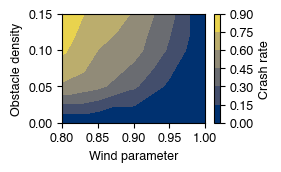

In [12]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

fig = plt.figure(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

fixed_size = 13
method = 'ip'

ax = fig.add_subplot()
# Get the x, y, z values
z_mc = crash_rates_mc.loc[fixed_size, :, :]
z_dp = crash_rates_dp.loc[fixed_size, :, :]
z_ip = crash_rates_ip.loc[fixed_size, :, :]

x = z_mc.index.get_level_values('wind_param')
y = z_mc.index.get_level_values('obstacle_density')

# Create a triangulation of the irregular grid
triang = tri.Triangulation(x, y)

# Plot the contour
if method == 'mc':
    levels = np.linspace(0, 1, 10)
    cs = ax.tricontourf(triang, z_mc, cmap='plasma')
elif method == 'ip':
    levels = np.linspace(0, 1, 10)
    cs = ax.tricontourf(triang, z_ip, cmap='cividis')
elif method == 'dp':
    levels = np.linspace(0, 1, 10)
    cs = ax.tricontourf(triang, z_dp, cmap='viridis')

# Add a colorbar to show the scale of the values in the contours
cbar = plt.colorbar(cs, ax=ax)

# Set labels for the axes
ax.set_xlabel('Wind parameter')
ax.set_ylabel('Obstacle density')
cbar.ax.set_ylabel('Crash rate')
ax.set_yticks(np.arange(0, 0.16, 0.05))
ax.set_xticks(np.arange(0.8, 1.01, 0.05))
plt.grid(False)


save = True
plt.tight_layout()
if save:
    plt.savefig(f'{fsp.fig_path}/4d-{method}-crash-rates-grid-size-{fixed_size}.pdf')
plt.show()

Simple 2D line plots with crash rates as functions of wind!

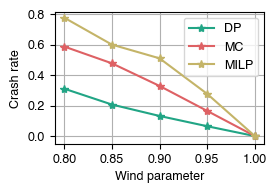

In [102]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

fig = plt.figure(figsize=(fsp.text_width * fsp.text_width_factor, 2))

fixed_size = 13
fixed_density = 0.1

ax = fig.add_subplot()
# Get the x, y, z values
y_mc = crash_rates_mc.loc[fixed_size, fixed_density, :]
y_dp = crash_rates_dp.loc[fixed_size, fixed_density, :]
y_ip = crash_rates_ip.loc[fixed_size, fixed_density, :]

x = y_mc.index.get_level_values('wind_param')

# Create the plot
cmap = plt.get_cmap('viridis')
ax.plot(x, y_dp, '-*', color=cmap.colors[150], label='DP')

cmap = plt.get_cmap('plasma')
ax.plot(x, y_mc, '-*', color=cmap.colors[150], label='MC')

cmap = plt.get_cmap('cividis')
ax.plot(x, y_ip, '-*', color=cmap.colors[200], label='MILP')

# Set labels for the axes
ax.set_xlabel('Wind parameter')
ax.set_ylabel('Crash rate')
ax.set_ylim(bottom=-0.05)

ax.set_xticks(np.arange(0.8, 1.01, 0.05))

plt.grid(True)
plt.legend()
plt.tight_layout()

save = False
if save:
    plt.savefig(f'{fsp.fig_path}/4d-line-crash-rates-gridsize-{fixed_size}-density-{fixed_density}.pdf')


plt.show()

### Plot cases wind = 1 IP solver times (single solution times) perhaps as a histogram for different grid sizes and obstacle densities

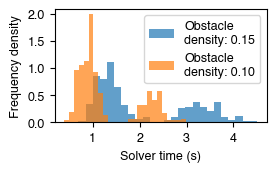

In [14]:
fig, ax = plt.subplots(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

MDP_ID_one = 134
MDP_ID_two = 133

df_sim_ip[(df_sim_ip['MDP_ID'] == MDP_ID_one) & (df_sim_ip['wind_param'] == 1)]['solver_time'].hist(bins = 25, density=True, alpha=0.7, label=f'Obstacle\ndensity: 0.15')
df_sim_ip[(df_sim_ip['MDP_ID'] == MDP_ID_two) & (df_sim_ip['wind_param'] == 1)]['solver_time'].hist(bins = 25, density=True, alpha=0.7, label=f'Obstacle\ndensity: 0.10')

plt.xlabel('Solver time (s)')
plt.ylabel('Frequency density')
plt.yticks([0, 0.5,1, 1.5, 2])
plt.tight_layout()
plt.grid(False)
plt.legend()

save = False
if save:
    plt.savefig(f'{fsp.fig_path}/4d-solver-time-hist-134-133.pdf')

plt.show()

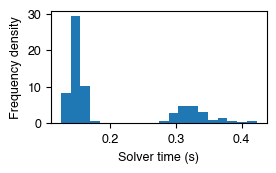

In [15]:
fig, ax = plt.subplots(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

df_sim_ip[(df_sim_ip['MDP_ID'] == 131) & (df_sim_ip['wind_param'] == 1)]['solver_time'].hist(bins = 20, density=True)
plt.xlabel('Solver time (s)')
plt.ylabel('Frequency density')
plt.tight_layout()
plt.grid(False)

save = False
if save:
    plt.savefig(f'{fsp.fig_path}/4d-solver-time-hist-131.pdf')

plt.show()

Below we plot ***mean or max*** solver times in problems with wind = 1, so we can get an idea of the trends of individual solution times.

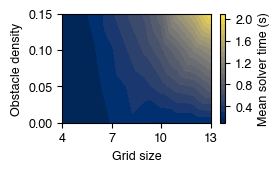

In [36]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

fig = plt.figure(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

ax = fig.add_subplot()


z_ip_time_envelopes = df_sim_ip[df_sim_ip['wind_param'] == 1].groupby(['grid_size', 'obstacle_density'])['solver_time'].mean() # could also do median, mean, etc.



x = z_ip_time_envelopes.index.get_level_values('grid_size')
y = z_ip_time_envelopes.index.get_level_values('obstacle_density')

# Create a triangulation of the irregular grid
triang = tri.Triangulation(x, y)

# Plot the contour

cs = ax.tricontourf(triang, z_ip_time_envelopes, cmap='cividis', levels = 20)

# Add a colorbar to show the scale of the values in the contours
cbar = plt.colorbar(cs, ax=ax)
cbar.locator = MaxNLocator(6) # this number sets maximum number of colour bar ticks

# Set labels for the axes
ax.set_xlabel('Grid size')
ax.set_ylabel('Obstacle density')
cbar.ax.set_ylabel(f'Mean solver time (s)')
ax.set_yticks(np.arange(0, 0.16, 0.05))
ax.set_xticks(np.arange(4,14,3))
plt.grid(False)


save = False
plt.tight_layout()
if save:
    pass
    # take care with these file names! MEAN/MAX
    #plt.savefig(f'{fsp.fig_path}/4d-ip-mean-solver-time-wind-1.pdf')
plt.show()

Now, we do a similar thing but with actual cumulative times in problems with uncertainty! ***Or maybe not***? There is not much of a point to that, we are more so interested in single solution times, since this is the relevant edge case that ultimately determines whether an onboard computer is capable of computing the necessary solutions or not.

# L1 Norm Performance Plotting

First do the usual scheme of fixing the wind: will see that most of these plots are not painting a clear picture, since the crash rates really muddy these figures!

/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/3001804220.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/3001804220.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/3001804220.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean 

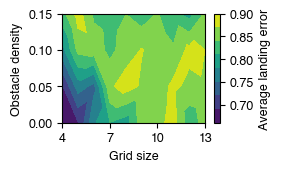

In [111]:
fig, ax = plt.subplots(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

df_sim_mc = df_sim[df_sim['sol_method'] == 'MC']
data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
df_sim_dp = df_sim[df_sim['sol_method'] == 'DP']
data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
df_sim_ip = df_sim[df_sim['sol_method'] == 'IP']
data_ip = df_sim_ip.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()

wp = 0.9
method = 'dp'

norm_data_mc = data_mc.loc[:, :, wp]['l1_norm']
norm_data_dp = data_dp.loc[:, :, wp]['l1_norm']
norm_data_ip = data_ip.loc[:, :, wp]['l1_norm']

# Get the x, y, z values
x = norm_data_mc.index.get_level_values('grid_size')
y = norm_data_mc.index.get_level_values('obstacle_density')
z_dp = norm_data_dp.values
z_mc = norm_data_mc.values
z_ip = norm_data_ip.values
# Create a triangulation for x and y axes
triang = tri.Triangulation(x, y)
# Create the contour plot
if method == 'dp':
    cntr = ax.tricontourf(triang, z_dp, cmap='viridis')
elif method == 'mc':
    cntr = ax.tricontourf(triang, z_mc, cmap='plasma')
elif method == 'ip':
    cntr = ax.tricontourf(triang, z_ip, cmap='cividis')
# Add a color bar
cbar = plt.colorbar(cntr, ax=ax)
cbar.ax.set_ylabel('Average landing error')
cbar.locator = MaxNLocator(5) # this number sets maximum number of colour bar ticks

# Set labels for the axes
ax.set_xlabel('Grid size')
ax.set_ylabel('Obstacle density')
ax.set_xticks(np.arange(4,14,3))
plt.tight_layout()

save = False
if save:
    plt.savefig(f'{fsp.fig_path}/4d-{method}-average-error-wind-{wp}')

plt.show()

Now we do it another way: we fix obstacle density plot grid size AND WIND on the horizontal axes, with L1 norm metrics on the colours!

/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/2781987905.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/2781987905.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/2781987905.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean 

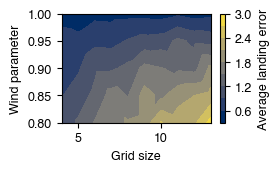

In [116]:
fig, ax = plt.subplots(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
data_ip = df_sim_ip.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()


density = 0.05
method = 'ip'

norm_data_mc = data_mc.loc[:, density, :]['l1_norm']
norm_data_dp = data_dp.loc[:, density, :]['l1_norm']
norm_data_ip = data_ip.loc[:, density, :]['l1_norm']

# Get the x, y, z values
x = norm_data_mc.index.get_level_values('grid_size')
y = norm_data_mc.index.get_level_values('wind_param')
z_dp = norm_data_dp.values
z_mc = norm_data_mc.values
z_ip = norm_data_ip.values

# Create a triangulation for x and y axes
triang = tri.Triangulation(x, y)

# Create the contour plot
if method == 'dp':
    cntr = ax.tricontourf(triang, z_dp, cmap='viridis')
elif method == 'mc':
    cntr = ax.tricontourf(triang, z_mc, cmap='plasma')
elif method == 'ip':
    cntr = ax.tricontourf(triang, z_ip, cmap='cividis')

# Add a color bar
cbar = plt.colorbar(cntr, ax=ax)
cbar.ax.set_ylabel('Average landing error')
cbar.locator = MaxNLocator(5) # this number sets maximum number of colour bar ticks
# Set labels for the axes
ax.set_xlabel('Grid size')
ax.set_ylabel('Wind parameter')
plt.tight_layout()
plt.show()

Similar thing now but by fixing grid size instead! This might be wise, since it will un-muddy the picture with regards to norms obtained in differently sized problems!

/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/1975748448.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/1975748448.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/1975748448.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean 

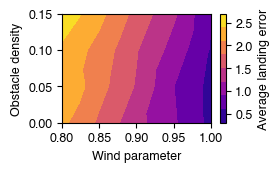

In [147]:
fig, ax = plt.subplots(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
data_ip = df_sim_ip.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()


fixed_size = 13
method = 'mc'

norm_data_mc = data_mc.loc[fixed_size, :, :]['l1_norm']
norm_data_dp = data_dp.loc[fixed_size, :, :]['l1_norm']
norm_data_ip = data_ip.loc[fixed_size, :, :]['l1_norm']

# Get the x, y, z values
x = norm_data_mc.index.get_level_values('wind_param')
y = norm_data_mc.index.get_level_values('obstacle_density')
z_dp = norm_data_dp.values
z_mc = norm_data_mc.values
z_ip = norm_data_ip.values

# Create a triangulation for x and y axes
triang = tri.Triangulation(x, y)

# Create the contour plot
if method == 'dp':
    cntr = ax.tricontourf(triang, z_dp, cmap='viridis')
elif method == 'mc':
    cntr = ax.tricontourf(triang, z_mc, cmap='plasma')
elif method == 'ip':
    cntr = ax.tricontourf(triang, z_ip, cmap='cividis')

# Add a color bar
cbar = plt.colorbar(cntr, ax=ax)
cbar.ax.set_ylabel('Average landing error')
cbar.locator = MaxNLocator(5) # this number sets maximum number of colour bar ticks

# Set labels for the axes
ax.set_xlabel('Wind parameter')
ax.set_ylabel('Obstacle density')

ax.set_xticks(np.arange(0.8, 1.01, 0.05))
plt.tight_layout()

save = False
if save:
    plt.savefig(f'{fsp.fig_path}/4d-{method}-average-error-grid-size-{fixed_size}.pdf')


plt.show()

# Some of these plots with flame-like shapes highlight the confouding factor of crashes
# Sometimes more obstacles seems to indicate better performance, but that's just because there are more crashes!

We will also try some simple 2D plots for clearer "sensitivity" and comparative analysis given some fixed problem. The only independent variable whose change does **not** entail a change in the environment layout is the wind parameter, so it is probably wise to put this in the independent variable axis.

/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/3908254323.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/3908254323.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_1288/3908254323.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean 

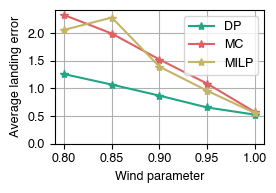

In [106]:
fig, ax = plt.subplots(figsize=(fsp.text_width * fsp.text_width_factor, 2))

data_mc = df_sim_mc.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean() # take mean values per benchmark MDP
data_dp = df_sim_dp.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()
data_ip = df_sim_ip.groupby(['grid_size', 'obstacle_density', 'wind_param']).mean()


fixed_size = 13
fixed_density = 0.1
method = 'ip'
norm_data_mc = data_mc.loc[fixed_size, fixed_density, :]['l1_norm']
norm_data_dp = data_dp.loc[fixed_size, fixed_density, :]['l1_norm']
norm_data_ip = data_ip.loc[fixed_size, fixed_density, :]['l1_norm']
# Get the x, y, z values
x = norm_data_mc.index.get_level_values('wind_param')
y_dp = norm_data_dp.values
y_mc = norm_data_mc.values
y_ip = norm_data_ip.values
# Create the plot
cmap = plt.get_cmap('viridis')
ax.plot(x, y_dp, '-*', color=cmap.colors[150], label='DP')
cmap = plt.get_cmap('plasma')
ax.plot(x, y_mc, '-*', color=cmap.colors[150], label='MC')
cmap = plt.get_cmap('cividis')
ax.plot(x, y_ip, '-*', color=cmap.colors[200], label='MILP')

# Set labels for the axes
ax.set_xlabel('Wind parameter')
ax.set_ylabel('Average landing error')
ax.set_ylim(bottom=0)

ax.set_xticks(np.arange(0.8, 1.01, 0.05))
plt.grid(True)
plt.legend()
plt.tight_layout()

save = False
if save:
    plt.savefig(f'{fsp.fig_path}/4d-line-landing-error-gridsize-{fixed_size}-density-{fixed_density}.pdf')
plt.show()

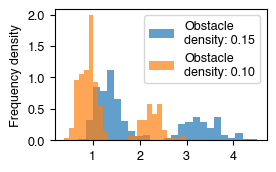

In [21]:
fig, ax = plt.subplots(figsize=(fsp.text_width * fsp.text_width_factor, 1.8))

MDP_ID_one = 134
MDP_ID_two = 133

df_sim_ip[(df_sim_ip['MDP_ID'] == MDP_ID_one) & (df_sim_ip['wind_param'] == 1)]['solver_time'].hist(bins = 25, density=True, alpha=0.7, label=f'Obstacle\ndensity: 0.15')
df_sim_ip[(df_sim_ip['MDP_ID'] == MDP_ID_two) & (df_sim_ip['wind_param'] == 1)]['solver_time'].hist(bins = 25, density=True, alpha=0.7, label=f'Obstacle\ndensity: 0.10')

#plt.xlabel('Solver time (s)')
plt.ylabel('Frequency density')
#plt.yticks([0, 0.5,1, 1.5, 2])
plt.tight_layout()
plt.grid(False)
plt.legend()

save = False
if save:
    plt.savefig(f'{fsp.fig_path}/4d-solver-time-hist-134-133.pdf')

plt.show()